In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap
from stardist import Config, StarDist, StarDistData
from skimage import io

np.random.seed(42)
lbl_cmap = random_label_cmap()

Using TensorFlow backend.


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
In general, training data (for input `X` with associated labels `Y`) can be provided via lists of numpy arrays, where each image can have a different size.
Alternatively, a single numpy array can also be used if all images have the same size.

In [2]:
X = sorted(glob('/home/prakash/Desktop/NAS/StarVoid/Sim/Raw/*.tif'))
Y = sorted(glob('/home/prakash/Desktop/NAS/StarVoid/Sim/GT/*.tif'))

Add noise to image

In [3]:
def noisy(image):
    
    row,col= image.shape
    mean = 0
    var = 0.05
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    noisy = image + gauss
    return noisy

In [4]:
X = list(map(imread,X))
Y = list(map(imread,Y))

Normalize images and fill small label holes.

In [5]:
X = [normalize(x,1,99.8) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 150/150 [00:01<00:00, 139.09it/s]


In [6]:
print(X[0][0][0])

0.07058824


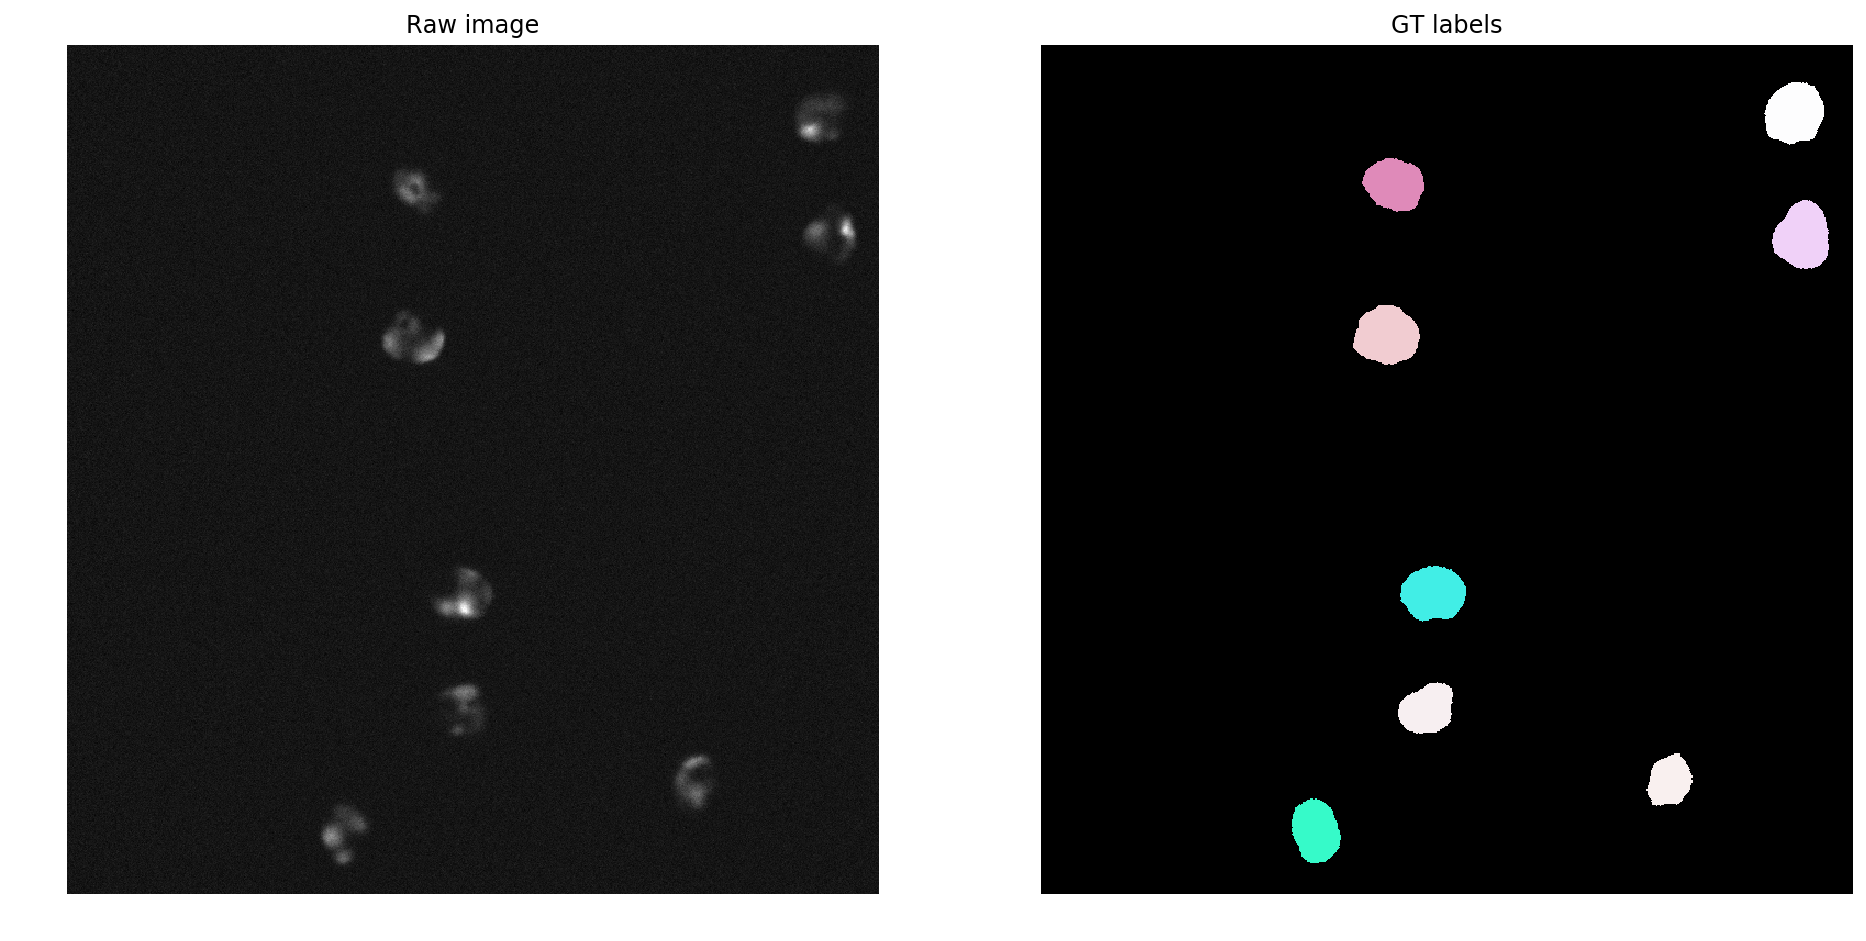

In [7]:
i = 9
img, lbl = X[i], Y[i]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
X = [noisy(x) for x in tqdm(X)]

100%|██████████| 150/150 [00:03<00:00, 43.56it/s]


-0.21766852910595047


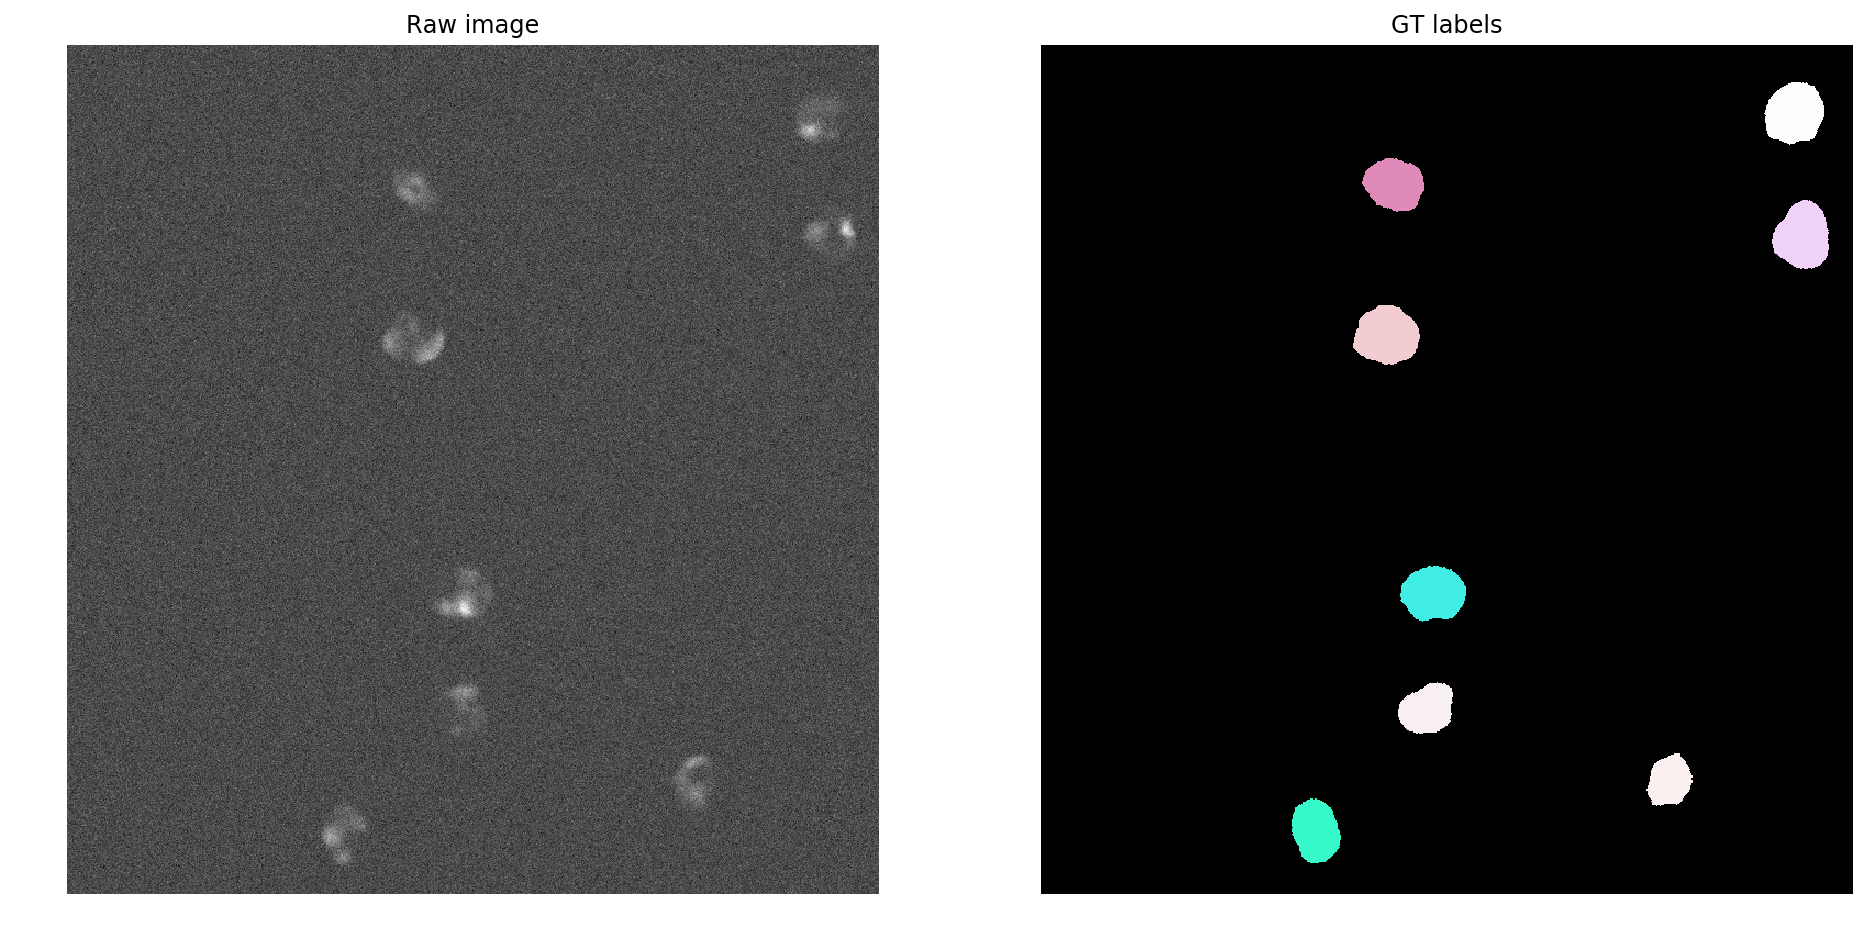

In [9]:
print(X[0][0][0])
i = 9
img, lbl = X[i], Y[i]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

Split into pretrain and test datasets

In [10]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_test = int(round(0.2*len(X)))
ind_pretrn, ind_test = ind[:-n_test], ind[-n_test:]
X_test, Y_test = [X[i] for i in ind_test] , [Y[i] for i in ind_test]
X_pretrn, Y_pretrn = [X[i] for i in ind_pretrn] , [Y[i] for i in ind_pretrn]
print('number of images: %3d' % len(X))
print('- training+validation:       %3d' % len(X_pretrn))
print('- test:     %3d' % len(X_test))
# for i in range(len(X_test)):
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/test_Raw/'+str(i)+'.tif',X_test[i])
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/test_GT/'+str(i)+'.tif',Y_test[i])

number of images: 150
- training+validation:       120
- test:      30


Split pretrain dataset into training and validation datasets

In [11]:
rng = np.random.RandomState(42)
ind = rng.permutation(len(X_pretrn))
n_val = int(round(0.15 * len(X_pretrn)))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X_pretrn[i] for i in ind_val]  , [Y_pretrn[i] for i in ind_val]
X_train, Y_train = [X_pretrn[i] for i in ind_train]  , [Y_pretrn[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_train))
print('- validation:     %3d' % len(X_val))
# for i in range(len(X_val)):
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/val_Raw/'+str(i)+'.tif',X_val[i])
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/val_GT/'+str(i)+'.tif',Y_val[i])
    
# for i in range(len(X_train)):
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/train_Raw/'+str(i)+'.tif',X_train[i])
#     io.imsave('/home/prakash/Desktop/NAS/StarVoid/dsb2018/New/train_GT/'+str(i)+'.tif',Y_train[i])

number of images: 150
- training:       102
- validation:      18


In [12]:
fraction_trn = 0.03; #Fraction of training data to choose for actual training
n_trn = int(round(fraction_trn*len(X_train)))
ind = list(range(0, n_trn))
ind_frac_train = ind [:n_trn]
X_trn, Y_trn = [X_train[i] for i in ind_frac_train]  , [Y_train[i] for i in ind_frac_train]

In [13]:
print(len(X_trn))

3


Training data consists of pairs of input image and label instances.

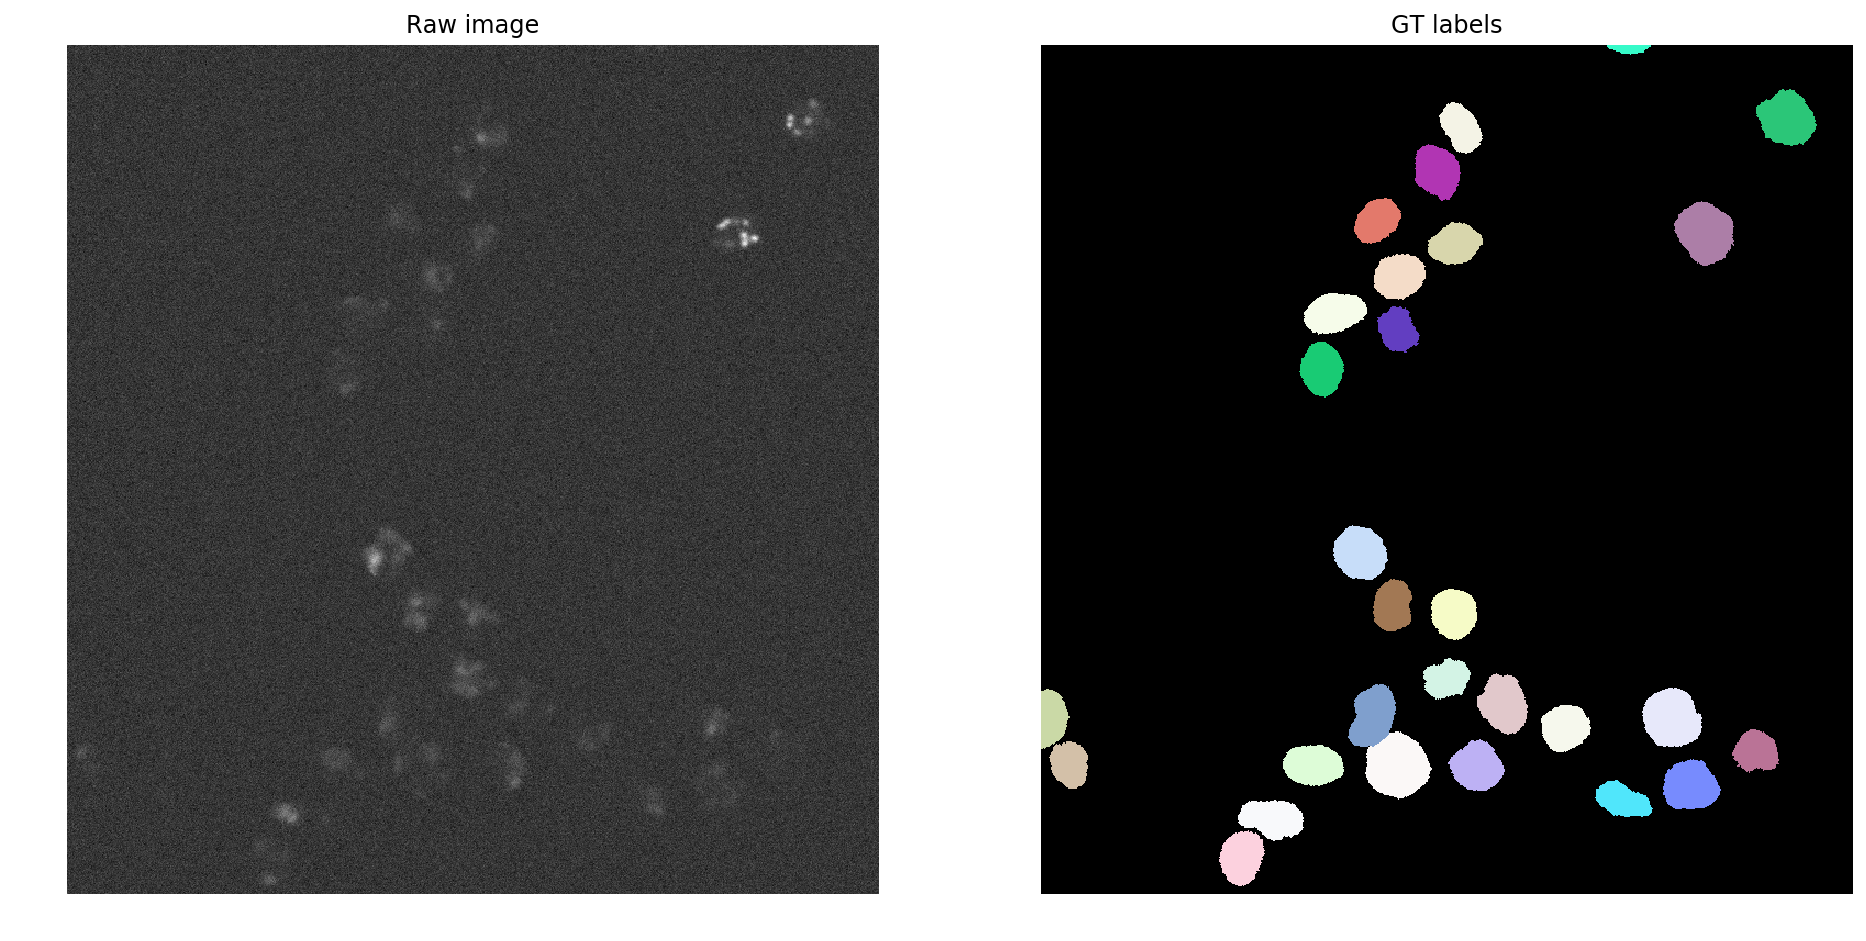

In [14]:
i = 9
img, lbl = X_train[i], Y_train[i]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Data for training StarDist

From the label instance image, all necessary data for training `StarDist` can be computed via `StarDistData`.  
Note that this here is only for illustration, since it happens automatically when calling `StarDist.train` (see below).

## Without shape completion

With `shape_completion = False` (see `Config` below), the trained `StarDist` model will *not* predict completed shapes for partially visible cells at the image boundary. This is the default behavior.

In [ ]:
np.random.seed(42)
data = StarDistData(X,Y,batch_size=1,n_rays=32,patch_size=(32,32),shape_completion=False)

In [ ]:
(img,dist_mask), (prob,dist) = data[1]

fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
                    ['Input image','Object probability','Distance mask','Distance (0°)']):
    a.imshow(d[0,...,0],cmap=cm)
    a.set_title(s)
plt.tight_layout()
None;

## With shape completion

With `shape_completion = True` (see `Config` below), the trained `StarDist` model will predict completed shapes for partially visible cells at the image boundary. For this to work, the image needs to be cropped, which is controlled by the `Config` parameter `train_completion_crop` (default 32), which should be chosen based on the size of the objects. Furthermore, it may be a good idea to increase `train_batch_size` to offset the reduced amount of pixels per training patch due to cropping.

In [ ]:
np.random.seed(42)
data = StarDistData(X,Y,batch_size=1,n_rays=32,patch_size=(32,32),shape_completion=True)

In [ ]:
# (img,dist_mask), (prob,dist) = data[1]

# fig, ax = plt.subplots(2,2, figsize=(12,12))
# for a,d,cm,s in zip(ax.flat, [img,prob,dist_mask,dist], ['gray','magma','bone','viridis'],
#                     ['Input image','Object probability','Distance mask','Distance (0°)']):
#     a.imshow(d[0,...,0],cmap=cm)
#     a.set_title(s)
# plt.tight_layout()
# None;

# Training

A `StarDist` model is specified via a `Config` object.

In [ ]:
print(Config.__doc__)

You can monitor the progress during training with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) by starting it from the current working directory:

    $ tensorboard --logdir=. --reload-interval=2

Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.


## Without shape completion

In [ ]:
conf = Config(train_batch_size=4, train_patch_size = (128,128), train_shape_completion=False)
print(conf)
vars(conf)

In [ ]:
model = StarDist(conf, name='stardist_no_shape_completion_MICCAI_sim3_GaussNoiseVar0.05', basedir='models')

In [ ]:
#%%capture train_log
model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

In [ ]:
# show train log
# train_log()

## With shape completion

In [ ]:
conf = Config(train_batch_size=7, train_shape_completion=True)
print(conf)
vars(conf)

In [ ]:
model = StarDist(conf, name='stardist_shape_completion', basedir='models')

In [ ]:
%%capture train_log
model.train(X_trn,Y_trn,validation_data=(X_val,Y_val))

In [ ]:
# show train log
# train_log()